In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
def linear_costs(x, y, z, theta):
    costs = (np.matmul(x,theta)-z)*(1-2*y)
    return costs

In [3]:
def paired_classifier(x, costs):
    f = []
    for cost in costs.T:
        f.append(LinearRegression(fit_intercept=False).fit(x, cost))
    return f

In [4]:
def obj_grad(objective, x, z, theta, n):
    zhat = np.matmul(x,theta)
    zdiff = zhat - z
    if objective=='MSE':
        #print(np.matmul(x.T,zdiff))
        grad = 2*np.matmul(x.T,zdiff)/n
        print(grad)
        return grad.flatten()
    
    elif objective=='dot_product':
        grad = np.matmul(x.T,z)/n
        return grad.flatten()
    
    else:
        return 0

In [5]:
def linear_proxies(x, y, z_all, C, iters, n, K, d, objective=None):
    theta_list = []
    grad_list = []
    for k in range(0,K):
        z = z_all[:,k].reshape(-1,1)
        theta = [np.random.rand(d,1)]
        grad_l = [0]
        
        for t in range(1, iters):
            costs = linear_costs(x, y, z, theta[t-1])
            f_s = paired_classifier(x, costs)
            val = []
            h = [0]*n
            
            for i, f in enumerate(f_s):
                h_s = f.predict(x)
                h[i] = h_s < 0
                val.append(np.sum(h_s[h[i]]))
                
            y_index = np.argmin(val)
            y_temp = y[:,y_index]
            h = h[y_index].astype(int)
            
            zhat = np.matmul(x,theta[t-1])
            zhat_sum = np.sum(zhat)
            z_sum = np.sum(z)
            err_points = np.abs(h-y_temp)
            err_cost = np.matmul((zhat-z).T,err_points)
            overall_diff = (zhat_sum/z_sum) - 1
            
            if np.abs(overall_diff) >= np.abs(err_cost):
                penalty = np.sign(overall_diff) * np.sum(x, axis=0)/z_sum
            else:
                penalty = np.sign(err_cost) * np.matmul(np.transpose(x),err_points)  
                penalty = penalty.flatten()
                
            grad_l.append(obj_grad(objective,x,z,theta[t-1],n) + C * penalty) 
            theta.append(theta[t-1] - (np.power(t, -1/2) * grad_l[t]).reshape(-1,1))
            
        theta_list.append(theta)
        grad_list.append(grad_l)
        
    return theta_list, grad_list

In [6]:
def calculate_hyperparameters(d, B, z, n, M, alpha):
    z_sum = np.sum(z)
    alpha_exp = alpha*z_sum/(1+n*M)
    
    C = (M**2+2*alpha_exp)/alpha_exp
    T = d**4*np.square(2*M*B+n*C*B/z_sum)/np.square(alpha_exp)
    return C, int(T)


In [7]:
#np.random.seed(1) #Good
np.random.seed(4) #Bad

#n = 3
#m = 1
#K = n
#d = n

#M = 1.2
#B = 1
#alpha = 0.1

#trials = 1

n = 100
m = 1
K = n
d = n

M = 1
B = 1
alpha=0.1
trials=1

intercept = np.ones(n).reshape(-1,1)
discrepancy = []

for i in range(0,trials):
    a = np.random.rand(1)
    b = np.random.rand(1)
   
    z_train = np.round(np.random.rand(n,K))
    theta = np.random.rand(n,n)
    
    x_train = np.matmul(z_train, np.linalg.inv(theta))
    x_train = np.hstack((intercept, x_train))
    y_train = np.round(np.random.rand(n,m))

    C, T = calculate_hyperparameters(d+1, B, z_train, n, M, alpha)
    coefficients, gradients = linear_proxies(x_train, y_train, z_train, C, 10000, n, K, d+1, objective='dot_product')

    final_model = np.mean(coefficients, axis=1)
   
    final_costs = linear_costs(x_train, y_train, z_train, final_model)
    prc = paired_classifier(x_train, final_costs)

    h_s = prc[0].predict(x_train)
    
    h = h_s < 0
    h_int = h.astype(int)
    h_err = h_int != y_train
    z_hat = np.matmul(x_train, final_model)
   
    for i in range(0,n):
        if sum(h_err[i])==0:
            discrepancy.append(0)
        else:
            discrepancy.append(np.mean(z_train[h_err[i]])/(np.mean(z_train)) - np.mean(z_hat[h_err[i]])/(np.mean(z_hat)))
    
print(discrepancy)
print(np.mean(discrepancy))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.07729047074300932, 0, 0, 0, 0, 0, 0, -0.0240862413443077, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.019802006976391562, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.032528994396791244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.014362305191388702, 0, 0, 0, 0, 0]
-0.0016807001865188852


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1., 95.]),
 array([-0.07729047, -0.06956142, -0.06183238, -0.05410333, -0.04637428,
        -0.03864524, -0.03091619, -0.02318714, -0.01545809, -0.00772905,
         0.        ]),
 <BarContainer object of 10 artists>)

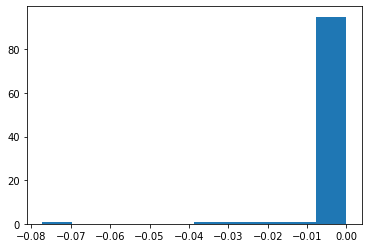

In [8]:
plt.hist(discrepancy)

#Portion of discrepancies that fall in good range